In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

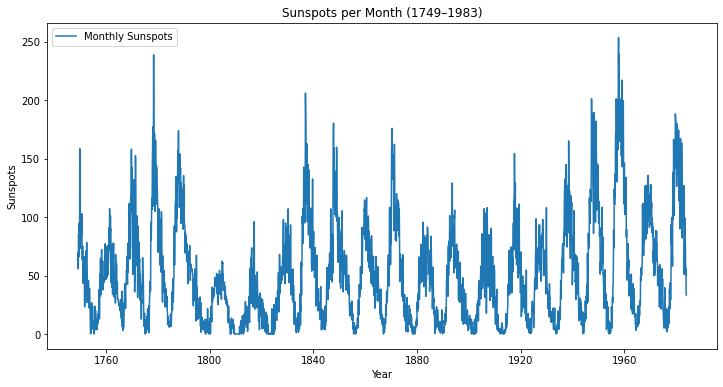

In [2]:
# 1. Load Data
df = pd.read_csv("../data/sunspots.csv")

# Convert to datetime
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Time series
sunspots = df['Sunspots']

# Plot original series
plt.figure(figsize=(12,6))
plt.plot(sunspots, label="Monthly Sunspots")
plt.title("Sunspots per Month (1749–1983)")
plt.xlabel("Year")
plt.ylabel("Sunspots")
plt.legend()
plt.show()

In [3]:
# 2. Stationarity check
result = adfuller(sunspots.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -9.56766751191308
p-value: 2.3334521438662885e-16


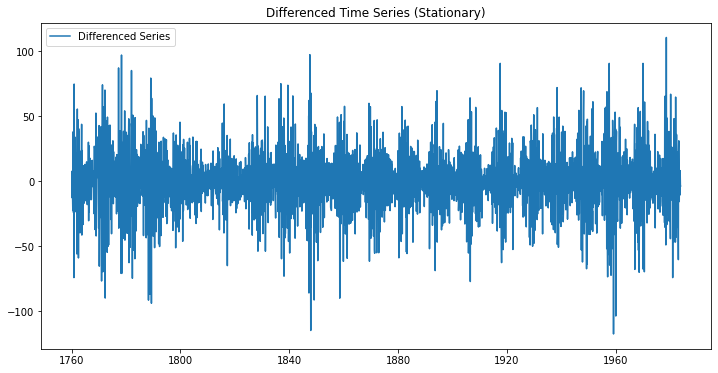

In [ ]:
# 3. Differencing (trend + seasonal, like in R code)
sunspots_diff = sunspots.diff().dropna()
sunspots_seasonal_diff = sunspots_diff.diff(132).dropna()  # 11 years * 12 months

plt.figure(figsize=(12,6))
plt.plot(sunspots_seasonal_diff, label="Differenced Series")
plt.title("Differenced Time Series (Stationary)")
plt.legend()
plt.show()

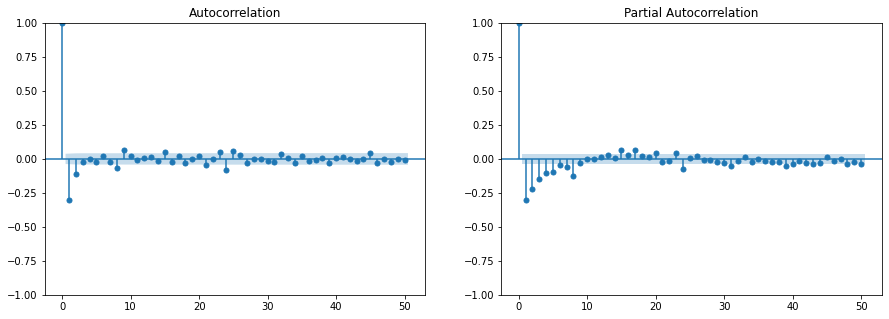

In [ ]:
# 4. ACF/PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_acf(sunspots_seasonal_diff, lags=50, ax=axes[0])
plot_pacf(sunspots_seasonal_diff, lags=50, ax=axes[1])
plt.show()

In [ ]:
# 5. Fit SARIMA model
model = SARIMAX(sunspots, 
                order=(8,1,7), 
                seasonal_order=(1,1,2,132), 
                enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit(disp=False)

print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# 6. Model diagnostics
results.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
# 7. Forecast
forecast = results.get_forecast(steps=132)  # forecast ~11 years ahead (monthly)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(sunspots, label="Observed")
plt.plot(forecast.predicted_mean, label="Forecast", color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title("Sunspot Forecast (Next 11-Year Cycle)")
plt.xlabel("Year")
plt.ylabel("Sunspots")
plt.legend()
plt.show()